In [1]:
import os
import h5py
from PIL import Image
import numpy as np

filename = os.path.expanduser("/gscratch/sciencehub/sebgab/Dev/data/armbench512x384_5_all.h5")
f = h5py.File(filename, "r")

def getImgAndBbox(i):
    img = Image.fromarray(f["data"][i])
    mask = f["mask"]

    boxes = []
    cats = []
    for cat in np.unique(mask[i]):
        if cat == 0 or cat == 255:
            continue
        mask_i = mask[i]
        mask_i = mask_i == cat
        bbox = [
                int(np.min(np.where(mask_i)[1])),  # x
                int(np.min(np.where(mask_i)[0])),  # y
                int(np.max(np.where(mask_i)[1]))
                - int(np.min(np.where(mask_i)[1])),  # width
                int(np.max(np.where(mask_i)[0]))
                - int(np.min(np.where(mask_i)[0])),  # height
            ]
        boxes.append(bbox)
        cats.append(cat)

    return img, boxes, cats

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_bbox(image, boxes, preds, cats=None):
    preds = preds * np.array([512, 384, 512, 384]) if preds else []
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for i, bbox in enumerate(boxes):
        # Unpack the bounding box coordinates
        x1, y1, w, h = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=3, edgecolor='y', facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            None if not cats else cats[i],
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )
    
    for i, bbox in enumerate(preds):
        # Unpack the bounding box coordinates
        x1, y1, w, h = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=3, edgecolor='r', facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            None,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    # Remove the axis ticks and labels
    ax.axis("off")

    # Show the plot
    plt.show()

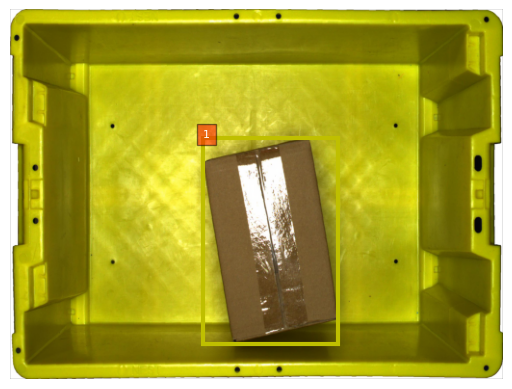

In [3]:
img, boxes, cats = getImgAndBbox(672*32 + 10)
plot_bbox(img, boxes, None, cats=cats)

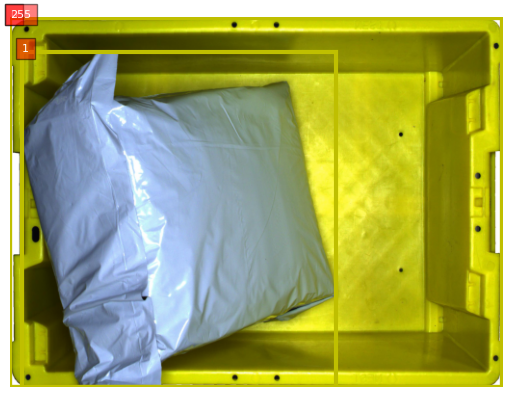

In [17]:
img, boxes, cats = getImgAndBbox(0*32 + 10)
plot_bbox(img, boxes, None, cats=cats)

In [3]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora"
model_base = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=model_base,
    model_name=get_model_name_from_path(model_path)
)

/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading LLaVA from base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Model is loaded...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora-merged"
model_base = "liuhaotian/llava-v1.5-7b"

get_model_name_from_path(model_path)

'llava-v1.5-7b-task-lora-merged'

In [15]:
model_path, model_base

('/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora',
 'liuhaotian/llava-v1.5-7b')

In [1]:
import os
os.environ['HF_HOME'] = '/gscratch/sciencehub/zanqil/cache/'

In [21]:
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = "llava/checkpoints/llava-v1.5-7b-task-lora_pad"
model_base = "liuhaotian/llava-v1.5-7b"

prompt = "Perform object detection on the given image. First, resize the image to 1x1, then answer: what are the bounding boxes of the objects in the image? Output should be in  the format of a list of lists, where each list represents a bounding box: [[x_min, y_min, width, height], [x_min, y_min, width, height], ...] \n\nx_min and y_min are placeholder for the coordinate of the top left corner of an object bounding box, width and height are placeholder for the width and height of the bounding box. \n\nThe x_min, y_min, width and height of the bounding box should be positive decimal numbers between 0 and 1. \n\n \n\nFor example, if there are two objects in the image, the bounding boxes of the objects could be [[0.13, 0.24, 0.37, 0.4], [0.5, 0.55, 0.23, 0.25]]."
image_file = "armbench/images/234.jpg,armbench/images/235.jpg"

args = type('Args', (), {
    "model_path": model_path,
    "model_base": model_base,
    "model_name": get_model_name_from_path(model_base),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0.2,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)

Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 2/2 [03:00<00:00, 90.13s/it] 


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...
[[0.0, 0.0, 1.0, 1.0], [0.1, 0.12, 0.48, 0.74], [0.54, 0.15, 0.34, 0.72]]


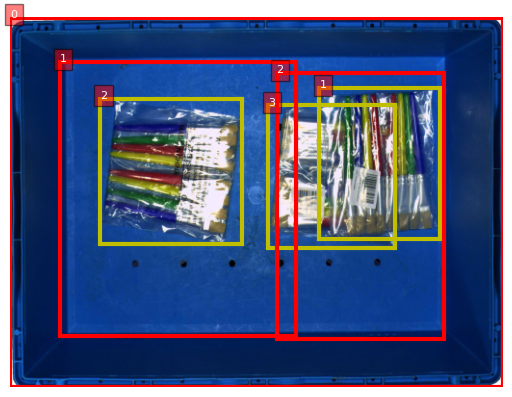

In [22]:
img, boxes, cats = getImgAndBbox(234)
plot_bbox(img, boxes, [[0.0, 0.0, 1.0, 1.0], [0.1, 0.12, 0.48, 0.74], [0.54, 0.15, 0.34, 0.72]], cats=cats)

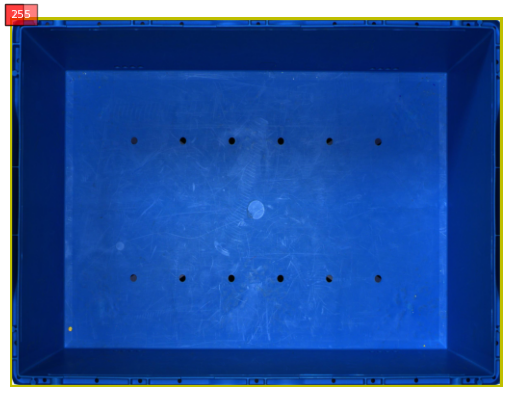

[0.         0.         0.99804688 0.99739583] 1
[0.         0.         0.99804688 0.99739583] 255


In [40]:
img, bboxes, cats =getImgAndBbox(99)
preds = [[0.1312, 0.2450, 0.3718, 0.4512], [0.5001, 0.5025, 0.2379, 0.2537]]

plot_bbox(img, bboxes, [], cats)
for i, b in enumerate(bboxes):
    print(b/np.array([512, 384, 512, 384]), cats[i])

### Eval on ARMBench

In [1]:
import json
import supervision as sv
import numpy as np
from PIL import Image
import os

def xyxy(bbox):
    x, y, w, h = bbox
    return [x - 0.5 * w, y - 0.5 * h, x + 0.5 * w, y + 0.5 * h]

target_json = None
img_dir = None

def predict(pred_target_files):
    global target_json, img_dir
    preds_targets = []

    for pred_file, test_file, img_folder, isxyxy in pred_target_files:
        preds = []
        targets = []
        img_dir = img_folder
        pred_json = json.load(open(pred_file, "r"))
        target_json = json.load(open(test_file, "r"))

        for pred, example in zip(pred_json, target_json):
            # get file name of the image
            img_name = example["image"]
            img = Image.open(os.path.join(img_dir, img_name))
            w, h = img.size
            text = pred["text"].replace("(", "[").replace(")", "]")
            try:
                pred_bbox = json.loads(text)
            except:
                pred_bbox = []
            if pred_bbox:
                pred_bbox = pred_bbox * np.array([w, h, w, h])
            if not isxyxy:
                pred_bbox = [xyxy(b) for b in pred_bbox]
            if len(pred_bbox) == 4 and isinstance(pred_bbox[0], float):
                pred_bbox = [pred_bbox]

            pred_bbox = np.array([np.append(b, [0, 1], axis=0) for b in pred_bbox])
            preds.append(pred_bbox)

            boxes = example["conversations"][1]["value"]
            boxes = boxes.replace("(", "[").replace(")", "]")
            boxes = json.loads(boxes)
            boxes = (boxes * np.array([w, h, w, h])).tolist()
            if not isxyxy:
                boxes = [xyxy(b) for b in boxes]
            boxes = [b + [0] for b in boxes]
            boxes = np.array(boxes)
            targets.append(boxes)
        pred_file_name = pred_file.split("/")[-1].split(".")[0]
        preds_targets.append((pred_file_name, preds, targets))
    return preds_targets

In [2]:
import pandas as pd
# set auto width
pd.set_option("display.max_colwidth", None)

def metrics(preds_targets_files):
    preds_targets = predict(preds_targets_files)
    df = pd.DataFrame(columns=["mAP50_95", "mAP50", "mAP75", "per_class_mAP50_95"])
    for name, preds, targets in preds_targets:
        metrics = sv.MeanAveragePrecision.from_tensors(targets=targets, predictions=preds)
        df.loc[name] = [
            metrics.map50_95,
            metrics.map50,
            metrics.map75,
            metrics.per_class_ap50_95,
        ]
    return df, preds_targets

In [23]:
df, preds_targets = metrics(
    [
        (
            "predictions/v1_5-3b-s2-ft-xywh.json",
            "../LLaVA/armbench/test/dataset.json",
            "../LLaVA/armbench/images",
            False,
        ),
        (
            "predictions/v1_5-3b-s2-ft-xyxy.json",
            "../LLaVA/armbench/test/dataset_xyxy.json",
            "../LLaVA/armbench/images",
            True,
        ),
        (
            "predictions/v1_5-3b-s2-ft-xyxy-sorted-arm.json",
            "../LLaVA/armbench/test/dataset_xyxy.json",
            "../LLaVA/armbench/images",
            True,
        ),
        # (
        #     "predictions/v1_5-3b-s2-ft-shelf-on-shelf.json",
        #     "../LLaVA/armbench/test/dataset_shelf.json",
        #     "../LLaVA/armbench/images",
        #     True,
        # ),
        # (
        #     "predictions/v1_5-3b-s2-ft-shelf-on-armbench.json",
        #     "../LLaVA/armbench/test/dataset_xyxy.json",
        #     "../LLaVA/armbench/images",
        #     True,
        # ),
        (
            "predictions/v1_5-3b-s2-ft-xyxy-sorted-v1.json",
            "../LLaVA/armbench/test/dataset_xyxy.json",
            "../LLaVA/armbench/images",
            True,
        ),
        (
            "predictions/v1_5-3b-s2-ft-xyxy-sorted-rag.json",
            "../LLaVA/armbench/test/dataset_xyxy.json",
            "../LLaVA/armbench/images",
            True,
        ),
    ]
)
df

,mAP50_95,mAP50,mAP75,per_class_mAP50_95
v1_5-3b-s2-ft-xywh,0.413653,0.800027,0.396358,"[[0.8000273672537666, 0.7192633211747461, 0.6596466395768835, 0.5710175571856606, 0.4783068088740467, 0.3963583553101939, 0.28219459287198556, 0.15193420856834985, 0.07071914681156445, 0.007060971255299264]]"
v1_5-3b-s2-ft-xyxy,0.502838,0.790475,0.549850,"[[0.7904749595728453, 0.7687744985731756, 0.7362284901197458, 0.7030010918201501, 0.6489974696205039, 0.5498504974888285, 0.40853778012768677, 0.2494382616597789, 0.13643689878610304, 0.03663819396264164]]"
v1_5-3b-s2-ft-xyxy-sorted-arm,0.514006,0.836695,0.516694,"[[0.8366949872949869, 0.8187422458172458, 0.7574818849926508, 0.7118243694328554, 0.6349462638022637, 0.5166940790881964, 0.44289416145501354, 0.2746191136191136, 0.12253819112213608, 0.02362174667220538]]"
v1_5-3b-s2-ft-xyxy-sorted-v1,0.528556,0.834667,0.553440,"[[0.834666866849433, 0.8166577580113806, 0.8025122046121593, 0.7385712421383647, 0.6611163720047479, 0.5534403265150393, 0.42953508531807844, 0.29150340577733497, 0.13504934333921534, 0.02250847652809109]]"
v1_5-3b-s2-ft-xyxy-sorted-rag,0.011471,0.041774,0.005123,"[[0.04177373675982718, 0.031549506993545924, 0.017301370563941, 0.008600530834747551, 0.006806969583566716, 0.005122786015849912, 0.0017759024064171122, 0.0017759024064171122, 0.0, 0.0]]"


In [6]:
# plot the predictions
import random
import cv2

def viz(i):
    preds = preds_targets[-1][1]
    targets = preds_targets[-1][2]
    img_filename = os.path.join(img_dir, target_json[i]["image"])
    image_bgr = cv2.imread(img_filename)
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=3)
    detections = sv.Detections(xyxy=preds[i][:, :4], mask=None)
    pred_image = box_annotator.annotate(
        scene=image_bgr.copy(), detections=detections
    )
    target_image = box_annotator.annotate(
        scene=image_bgr.copy(),
        detections=sv.Detections(xyxy=targets[i][:, :4], mask=None),
    )
    sv.plot_images_grid(
        images=[pred_image, target_image],
        grid_size=(1, 2),
        titles=[f"{img_filename}\n prediction", "target"],
    )

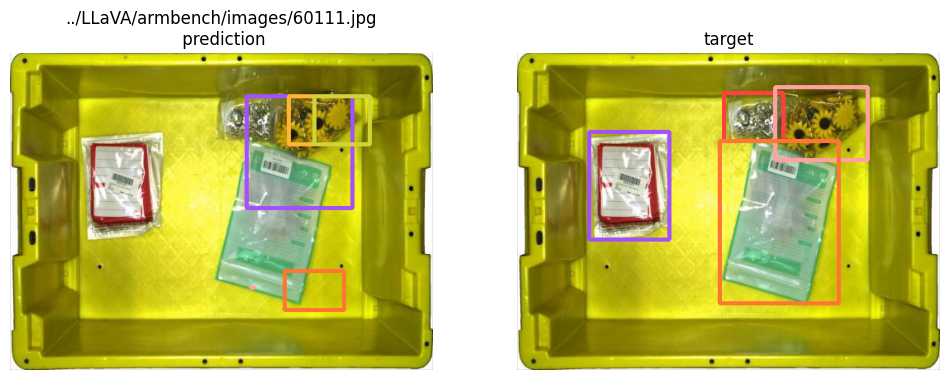

In [8]:
viz(random.randint(0, len(target_json)-1))

### STOW

In [13]:
df, preds_targets = metrics(
    [
        (
            "predictions/v1_5-3b-s2.json",
            "../LLaVA/data/stow/test/dataset.json",
            "../LLaVA/data/stow",
            True
        ),
        (
            "predictions/v1_5-3b-s2-ft-shelf.json",
            "../LLaVA/data/stow/test/dataset.json",
            "../LLaVA/data/stow",
            True
        ),
        (
            "predictions/v1_5-3b-s2-ft-xyxy-sorted-stow.json",
            "../LLaVA/data/stow/test/dataset.json",
            "../LLaVA/data/stow",
            True
        ),
        (
            "predictions/v1_5-3b-s2-ft-cotrain.json",
            "../LLaVA/data/stow/test/dataset.json",
            "../LLaVA/data/stow",
            True
        ),
        (
            "predictions/v1_5-3b-s2-ft-shelf-arm.json",
            "../LLaVA/data/stow/test/dataset.json",
            "../LLaVA/data/stow",
            True
        ),
    ]
)
df

,mAP50_95,mAP50,mAP75,per_class_mAP50_95
v1_5-3b-s2,0.032573,0.093983,0.025236,"[[0.09398344941038891, 0.06646684400255828, 0.05104274097879184, 0.045613596194181115, 0.03297412055770584, 0.025235757111262504, 0.010417210831047841, 0.0, 0.0, 0.0]]"
v1_5-3b-s2-ft-shelf,0.168112,0.412581,0.118767,"[[0.41258090562335265, 0.35821043824548177, 0.2873581679316331, 0.23538742774539528, 0.168320857695892, 0.11876694311917771, 0.07026999389398006, 0.02401441823151401, 0.005200796616433295, 0.0010113568769149514]]"
v1_5-3b-s2-ft-xyxy-sorted-stow,0.289674,0.578046,0.261703,"[[0.5780457453961583, 0.5195927229607776, 0.47316460806106175, 0.4085772389249857, 0.3287530367485088, 0.26170349043100616, 0.17584112362386645, 0.10104359657813597, 0.03902641160416659, 0.010993025855276822]]"
v1_5-3b-s2-ft-cotrain,0.338231,0.607602,0.356500,"[[0.6076015880543567, 0.5694017718284006, 0.516780745981126, 0.479808296923387, 0.4174306804078576, 0.35650041246342273, 0.2534212236053802, 0.13384811469569632, 0.042360783878084625, 0.005159997761271389]]"
v1_5-3b-s2-ft-shelf-arm,0.058765,0.179330,0.034209,"[[0.17932985157400727, 0.13169841041387698, 0.09586145425951612, 0.06805199315126045, 0.050707409784779195, 0.0342093290066217, 0.016586739932993484, 0.009472572662058337, 0.0017363610809415528, 0.0]]"


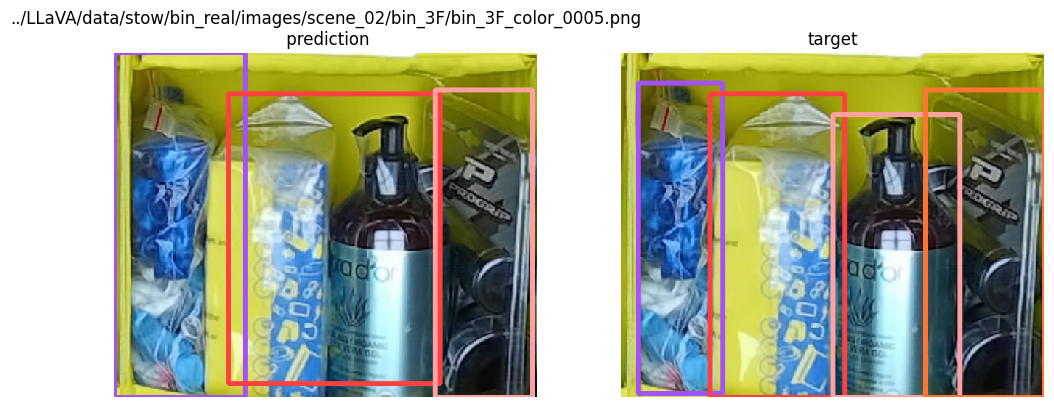

In [14]:
viz(random.randint(0, len(target_json)-1))

In [1]:
import os
os.environ['HF_HOME'] = '/gscratch/sciencehub/zanqil/cache/'

In [19]:

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
import os

VILA_PATH = "/gscratch/sciencehub/zanqil/VILA"
# model_path = os.path.join(VILA_PATH, "checkpoints/v1_5-3b-s2-ft-xyxy-sorted")
model_path = os.path.join(VILA_PATH, "checkpoints/v1_5-3b-s2-ft-shelf-arm")
# model_path = "Efficient-Large-Model/VILA1.5-3B-s2"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path, model_name=get_model_name_from_path(model_path)
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
from llava.eval.run_vila import eval_model

image_folder = "/gscratch/sciencehub/zanqil/LLaVA/armbench/images"
# image_files = ['google.png', 'apple.png', 'nvidia.png']
image_files = ['60100.jpg', '60148.jpg']
image_files = [os.path.join(image_folder, f) for f in image_files]
# prompt = "<image> is famous for its search engine. <image> is famous for Mac and iPhone. <image>"
prompt = "Find all instances of objects. Format the result as a list of tuples, i.e. [(xmin1, ymin1, xmax1, ymax1), (xmin2, ymin2, xmax2, ymax2), ...], where xmin and ymin are the normalized pixel locations of the object top left corner, and xmax and ymax are the normalized pixel locations of the ojbect bottom right corner. All values of xmin, ymin, xmax, and ymax should be between 0 and 1. <image> [(0.24, 0.39, 0.92, 0.91), (0.26, 0.10, 0.90, 0.59)]. <image> "
eval_args = type('Args', (), {
            "model_path": model_path,
            "model_base": None,
            "query": prompt,
            "conv_mode": None,
            # "conv_mode": 'v1',
            # "conv_mode": 'vicuna_v1_nosys',
            "image_file": ",".join(image_files),
            "video_file": None,
            "sep": ",",
            "temperature": 0.2,
            "top_p": None,
            "num_beams": 1,
            "max_new_tokens": 512
        })()

output = eval_model(eval_args, model, tokenizer, image_processor)
output


input:  Find all instances of objects. Format the result as a list of tuples, i.e. [(xmin1, ymin1, xmax1, ymax1), (xmin2, ymin2, xmax2, ymax2), ...], where xmin and ymin are the normalized pixel locations of the object top left corner, and xmax and ymax are the normalized pixel locations of the ojbect bottom right corner. All values of xmin, ymin, xmax, and ymax should be between 0 and 1. <image> [(0.24, 0.39, 0.92, 0.91), (0.26, 0.10, 0.90, 0.59)]. <image> 
torch.Size([2, 3, 768, 768])
[(0.24, 0.11, 0.85, 0.89), (0.25, 0.12, 0.27, 0.13), (0.27, 0.12, 0.30, 0.13), (0.27, 0.12, 0.30, 0.13)]


'[(0.24, 0.11, 0.85, 0.89), (0.25, 0.12, 0.27, 0.13), (0.27, 0.12, 0.30, 0.13), (0.27, 0.12, 0.30, 0.13)]'